# EJERCICIO: COLOR

### a) Realiza una calibración precisa de tu cámara mediante múltiples imágenes de un chessboard

Para la resolución de este apartado se ha hecho uso del script ```calibrate.py```, cuyo código queda listado justo debajo. Este script realiza una calibración precisa de la cámara a partir de un conjunto de imágenes suministradas como input. El programa devolverá el error de ajuste (**RMS**), la matriz de calibración de cámara ***K*** y los coeficientes de distorsión radial. El primer elemento de *K* se tratará de la longitud focal ***f*** medida en pixels.

Las imágenes que le suministramos al programa estarán en formato PNG y tendrán un tamaño reducido a un 20% del original (comando ```magick convert -resize 20% *.jpg *.png```).

In [51]:
#!/usr/bin/env python

import numpy             as np
import cv2               as cv
import matplotlib.pyplot as plt
import skimage.io        as io

import sys
from glob import glob

files = glob("ctmlogitech/png/*.png")

square_size = 1
pattern_size = (9, 6)
pattern_points = np.zeros( (np.prod(pattern_size), 3), np.float32 )
pattern_points[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
pattern_points *= square_size

obj_points = []
img_points = []
h, w = 0, 0
for fn in files:
    print('processing %s...' % fn)
    img = cv.imread(fn, cv.IMREAD_GRAYSCALE)
    if img is None:
      print("Failed to load", fn)
      continue

    h, w = img.shape[:2]
    found, corners = cv.findChessboardCorners(img, pattern_size)
    if found:
        term = ( cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_COUNT, 30, 0.1 )
        cv.cornerSubPix(img, corners, (5, 5), (-1, -1), term)
    if not found:
        print('chessboard not found')
        continue
    img_points.append(corners.reshape(-1, 2))
    obj_points.append(pattern_points)

    print('ok')

rms, camera_matrix, dist_coefs, rvecs, tvecs = cv.calibrateCamera(obj_points, img_points, (w, h), None, None)

print("RMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())

processing ctmlogitech/png\r20-0.png...
ok
processing ctmlogitech/png\r20-1.png...
ok
processing ctmlogitech/png\r20-10.png...
ok
processing ctmlogitech/png\r20-11.png...
ok
processing ctmlogitech/png\r20-12.png...
ok
processing ctmlogitech/png\r20-13.png...
ok
processing ctmlogitech/png\r20-14.png...
ok
processing ctmlogitech/png\r20-15.png...
ok
processing ctmlogitech/png\r20-2.png...
ok
processing ctmlogitech/png\r20-3.png...
ok
processing ctmlogitech/png\r20-4.png...
ok
processing ctmlogitech/png\r20-5.png...
ok
processing ctmlogitech/png\r20-6.png...
ok
processing ctmlogitech/png\r20-7.png...
ok
processing ctmlogitech/png\r20-8.png...
ok
processing ctmlogitech/png\r20-9.png...
ok
RMS: 1.571468395778097
camera matrix:
 [[811.72485192   0.         423.0058124 ]
 [  0.         815.82669901 344.14988199]
 [  0.           0.           1.        ]]
distortion coefficients:  [-0.09190962 -0.19952688 -0.00946322 -0.00511857  0.41674454]


Observamos que obtenemos una distancia focal ***f*** **= 811.725 pixels** (primer elemento de la matriz de la cámara), junto con un error de ajuste de 1.57. No obstante, no hemos de olvidar que este script se ha ejecutado con un surtido de imágenes de **tamaño reducido**. En nuestro caso, las imágenes miden un 20% de su tamaño original, por lo que habría que multiplicar el valor obtenido por 5, lo que nos da una **distancia focal precisa de 4058.625 pixels.**



### b) Haz una calibración aproximada con un objeto de tamaño conocido y compara con el resultado anterior.

Para la resolución de este ejercico se tomará una imagen de un objeto de tamaño conocido a una cierta distancia. De esta forma, teniendo en cuenta la distancia a la que se tomó la foto y la distancia entre 2 puntos medida tanto en cm como en pixels, seremos capaces de obtener un valor aproximado de la distancia focal ***f***, el cual se espera que se aproxime al dado por la matriz ***K*** en un 30%. 

Se ha tomado una fotografía de una regla con una resolución de 4264 x 3468 pixels (*W x H*) y a una distancia de 20 cm.

(694, 925, 3)


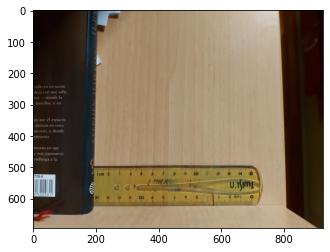

In [52]:
# Aplicamos a la imagen una reducción de tamaño del 80% (imagick convert -resize 20% regla-via.jpg regla-via.png)
img = io.imread('regla-via.png')

print(img.shape)
plt.imshow(img)

El objetivo será medir una distancia cualquiera desde un punto de la regla hasta otro. De esta forma, conoceremos la **distancia real** en cm de esos 2 puntos. Por otra parte, **también necesitamos esa distancia medida en pixeles**. Para ello, usando la imagen original, medimos la distancia entre esos mismos 2 puntos con cualquier herramienta que nos sirva como medidor de pixels. En nuestro caso, se ha hecho uso de la regla online [***Pixel Ruler***](https://www.rapidtables.com/web/tools/pixel-ruler.html).
Decidimos medir una distancia ***X*** de **10 cm**, lo que se traduce en una longitud en la imagen ***u*** de **1774 pixels**. Sabiendo que la fotografía se ha tomado a una distancia ***Z*** de **20 cm**, podemos proceder a aplicar una calibración aproximada mediante la fórmula para conseguir la distancia focal ***f***:

$$u= f \frac{X}{Z}$$

In [53]:
realf = 4058.625
f = 1774 / (10/20)
print(str(f) + " pixels")

3548.0 pixels


Obtenemos un valor menor que el calculado por la calibración precisa. Sin embargo, **dicha distancia tan solo es un 14.39% mayor que el valor aproximado**, lo cual entra dentro de nuestros cálculos.



### c) Determina a qué altura hay que poner la cámara para obtener una vista cenital completa de un campo de baloncesto.

Si tenemos en cuenta que las dimensiones de una cancha de baloncesto son de **28 x 15** m y quisiéramos que dicho campo estuviera contenido dentro de la imagen, habría que calcular la distancia de posición de la cámara para que pudiera captar, como mínimo, una imagen de 28 metros de ancho y 15 de largo. Esto puede calcularse fácilmente aplicando las bases de la trigonometría si pensamos en la cámara como uno de los ángulo interiores de un triángulo rectángulo, cuyo cateto opuesto es la mitad de una dimensión y contiguo, la distancia.

El objetivo sería calcular cuál de las 2 distancias (la necesaria para capturar 28 m a lo ancho y la necesaria para 15 m a lo largo) vence a la otra, de esta forma obtendremos la distancia mínima a la que deberíamos colocar la cámara. Para ello, se debe calcular el FOV tanto horizontal (anchura) como vertical (altura). De nuevo, aplicando trigonometría básica pero con las distancias en pixels que conocemos (*f,w,h*), podremos hallar estos ángulos.

In [54]:
FOVh = np.degrees(np.arctan(4264/2/f)*2)
FOVv = np.degrees(np.arctan(3468/2/f)*2)
print("Con la distancia focal aproximada, se tiene un FOV horizontal de " + str(round(FOVh,3)) +" grados y un FOV vertical de " +str(round(FOVv,3)) +" grados.")

FOVh = np.degrees(np.arctan(4264/2/realf)*2)
FOVv = np.degrees(np.arctan(3468/2/realf)*2)
print("Con la distancia focal precisa, se tiene un FOV horizontal de " + str(round(FOVh,3)) +" grados y un FOV vertical de " +str(round(FOVv,3)) +" grados.")

Con la distancia focal aproximada, se tiene un FOV horizontal de 62.003 grados y un FOV vertical de 52.092 grados.
Con la distancia focal precisa, se tiene un FOV horizontal de 55.426 grados y un FOV vertical de 46.268 grados.


A partir de ahora, se realizarán los cálculos con la *f* precisa. Ahora que conocemos los ángulos, procedemos a calcular a qué distancia debemos posicionarnos.

In [55]:
Xh = 28/2/(np.tan(np.radians(FOVh/2))) # Distancia minima para caputrar 28 metros de ancho 
Xv = 15/2/(np.tan(np.radians(FOVv/2))) # Distancia minima para caputrar 15 metros de alto
print(Xh,Xv)

26.65138367729831 17.554606401384085


En conclusión, deberemos situarnos a una distancia de **27 metros** para poder abarcar una cancha de baloncesto al completo dentro de una imagen de nuestras resoluciones.



### d) Haz una aplicación para medir el ángulo que definen dos puntos marcados con el ratón en el imagen.

(El script **CALIBRACION.py** contiene todo el código listado abajo junto con un parser de argumentos ```argparser```)

Procederemos con el valor de *f* preciso que obtuvimos con la matriz *K* dado que trabajaremos con una imagen con un tamaño reducido a un 20% del original, cuyo formato fue el mismo de las imágenes a partir de las cuales se calculó *K*.

Mostraremos la imagen con una resolución de 1300 x 800, por lo que los ángulos máximos esperados son:

In [56]:
f = 811.72485192 #Vamos a leer una imagen con un tamaño reducido al 20%, por lo que usaremos la f que nos dio inicialmente K
FOVh = np.degrees(np.arctan(1300/2/f)*2)
FOVv = np.degrees(np.arctan(800/2/f)*2)
print("Ángulo horizontal máximo = " + str(round(FOVh,3)) +", vertical máximo = " +str(round(FOVv,3)) +" grados.")

Ángulo horizontal máximo = 77.373, vertical máximo = 52.466 grados.


El código de abajo produce la aplicación que se pide: el usuario podrá clickear en la imagen y se medirá la distancia y el ángulo entre los puntos clickados. Se precisa de un ```manejador``` para que el programa actúe a los eventos de clickado.

In [57]:
from   umucv.util  import putText
from   collections import deque
from   umucv.util  import Help

help = Help(
"""
HELP WINDOW

Left-click: draw circle
Right-Click: clear

ESC: exit

h: show/hide help
""")

# Funcion que se ejecuta cada vez que clickamos en la imagen
# Sirve para añadir o eliminar los puntos e indicar si se ha modificado la imagen
def manejador(event, x, y, flags, param):
    global points, modified
    if event == cv.EVENT_LBUTTONDOWN:
        print(x,y) 
        points.append((x,y))
        modified = True
    elif event == cv.EVENT_RBUTTONDOWN:
        points.clear()
        print("CLEARED")
        global image, original_image
        image = original_image.copy()
        modified = True


# Dibuja el punto
def drawCircle(points, frame):
    for p in points:
        cv.circle(frame,p, 10, (0,0,255), -1)

# Dibuja la distancia entre 2 puntos y el angulo
def drawDistancesAndAngles(points,frame,f):
    l = list(points)
    for (p1,p2) in zip(l,l[1:]):
        cv.line(frame,p1,p2,(0,255,0))
        x1,y1 = p1
        x2,y2 = p2
        dist = round((abs(x2**2-x1**2) + abs(y2**2-y1**2))**0.5,2) #Redondeamos a 2 decimales
        (midx,midy) = ((x1+x2)//2, (y1+y2)//2)
        alpha = np.degrees(abs(np.arctan(dist/2/f)))*2
        putText(frame,str(dist)+' pixels',(midx,midy))
        putText(frame,'alpha = ' + str(round(alpha,2)) +' degrees', (midx,midy+25))


cv.namedWindow("image")
cv.setMouseCallback("image", manejador)

MAX = 2
points = deque([], maxlen = MAX)
image = cv.resize(cv.imread("regla-via.png"), (1300,800))
original_image = image.copy()
print(image.shape)
modified = True #Variable global para no estar llamando continuamente a imshow
cont = True
while cont:
    
    help.show_if(key, ord('h'))

    # help.show_if(key, ord('h'))
    key = cv.waitKey(1)

    if key == 27:
        cont = False
    
    elif modified:
        image = original_image.copy();
        drawCircle(points,image)
        drawDistancesAndAngles(points,image,f)
        # No dibujamos la imagen a no ser que haya cambios o sea la primera vez que la mostramos
        cv.imshow('image',image)
        modified = False

cv.destroyAllWindows()

(800, 1300, 3)
